In [157]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [158]:
df = pd.read_csv('train_v9rqX0R.csv')

In [159]:
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [160]:
# checking how many different categories in each column.

unique_lengths = {col: len(df[col].unique()) for col in df.columns}
unique_lengths

{'Item_Identifier': 1559,
 'Item_Weight': 416,
 'Item_Fat_Content': 5,
 'Item_Visibility': 7880,
 'Item_Type': 16,
 'Item_MRP': 5938,
 'Outlet_Identifier': 10,
 'Outlet_Establishment_Year': 9,
 'Outlet_Size': 4,
 'Outlet_Location_Type': 3,
 'Outlet_Type': 4,
 'Item_Outlet_Sales': 3493}

# Data cleaning

## Gendral checks

In [161]:
# helper function to describe cols.
def col_describer(col):
    summary = col.describe()
    missing_count = col.isna().sum()
    # printing basic repetative tasks.
    print(summary)
    print(f"Missing: {missing_count} ({(missing_count / len(df)) * 100:.2f}%)")
    print(f"Distinct: {col.nunique()} ({(col.nunique() / len(df)) * 100:.2f}%)")
    
def target_corr_check_for_categorical(col):
    col = col.name
    df_encoded = pd.get_dummies(df, columns=[col], drop_first=True)
    corr_matrix = df_encoded.filter(regex=f'^{col}|Item_Outlet_Sales').select_dtypes(include=['number', 'bool']).corr()
    sales_corr = corr_matrix['Item_Outlet_Sales'].sort_values(ascending=False)
    print(sales_corr)

def target_corr_check_for_numerical(col):
    col = col.name
    corr_matrix = df.filter(regex=f'^{col}|Item_Outlet_Sales').select_dtypes(include=['number', 'bool']).corr()
    sales_corr = corr_matrix['Item_Outlet_Sales'].sort_values(ascending=False)
    print(sales_corr)

In [162]:
df.info()

# Finding columns with null values.
#concluded Item_Weight, Outlet_Size are the only columns with null values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [163]:
df[df.duplicated()] # no duplicated rows.

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


## Item_Fat_Content column

In [164]:
df['Item_Fat_Content'].value_counts() # essentially only 2 categories so converting them alike.

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

In [165]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'})

In [166]:
col_describer(df['Item_Fat_Content'])

count        8523
unique          2
top       Low Fat
freq         5517
Name: Item_Fat_Content, dtype: object
Missing: 0 (0.00%)
Distinct: 2 (0.02%)


In [167]:
df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

In [168]:
target_corr_check_for_categorical(df['Item_Fat_Content'])

Item_Outlet_Sales           1.000000
Item_Fat_Content_Regular    0.018719
Name: Item_Outlet_Sales, dtype: float64


In [169]:
# no significant corr but we can keep it for biggermodels to see if score rises.

## Item_Type column

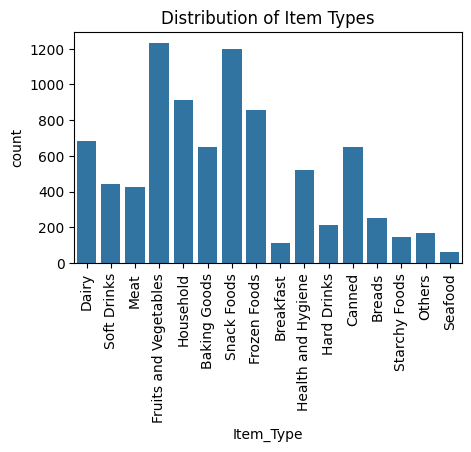

In [170]:
plt.figure(figsize=(5, 3))
sns.countplot(x='Item_Type', data=df)
plt.xticks(rotation=90)
plt.title('Distribution of Item Types')
plt.show()

In [171]:
target_corr_check_for_categorical(df['Item_Type']) # almost no corr for entire column with sales. one hot encodeing will only increase dimentionality. 
# still keeping it for future.

Item_Outlet_Sales                  1.000000
Item_Type_Fruits and Vegetables    0.025950
Item_Type_Snack Foods              0.022782
Item_Type_Household                0.015701
Item_Type_Starchy Foods            0.015039
Item_Type_Dairy                    0.008858
Item_Type_Canned                   0.007387
Item_Type_Seafood                  0.007380
Item_Type_Breads                   0.002332
Item_Type_Meat                    -0.002995
Item_Type_Hard Drinks             -0.003956
Item_Type_Breakfast               -0.004656
Item_Type_Frozen Foods            -0.009482
Item_Type_Others                  -0.021267
Item_Type_Soft Drinks             -0.024040
Item_Type_Health and Hygiene      -0.025587
Name: Item_Outlet_Sales, dtype: float64


## Item_Weight

In [172]:
col_describer(df['Item_Weight'])

count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64
Missing: 1463 (17.17%)
Distinct: 415 (4.87%)


In [173]:
# imputing nans with the mean obtained from groups of ['Item_Type', 'Item_Fat_Content', 'Item_Identifier'].
# checked the values in the grouped_stats DF max value count of each combination was only 8. and the weight were perfectly same so proceded with this approach.
# Iterating NAN df and using index maps will make the process siginificantly quicker.

grouped_stats = df.groupby(['Item_Type', 'Item_Fat_Content', 'Item_Identifier']).describe()
for index, row in df[df['Item_Weight'].isna()].iterrows():
    class_mean = grouped_stats.loc[row['Item_Type'],row['Item_Fat_Content'],row['Item_Identifier']]['Item_Weight']['mean']
    df.at[index,'Item_Weight'] = class_mean 

In [174]:
df[df['Item_Weight'].isna()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564
1922,FDK57,NaN,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280
4187,FDE52,NaN,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046
5022,FDQ60,NaN,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098


In [175]:
# droping 4 rows will not make significant diff.
df.dropna(subset='Item_Weight',inplace=True)

<Axes: xlabel='Item_Weight', ylabel='Count'>

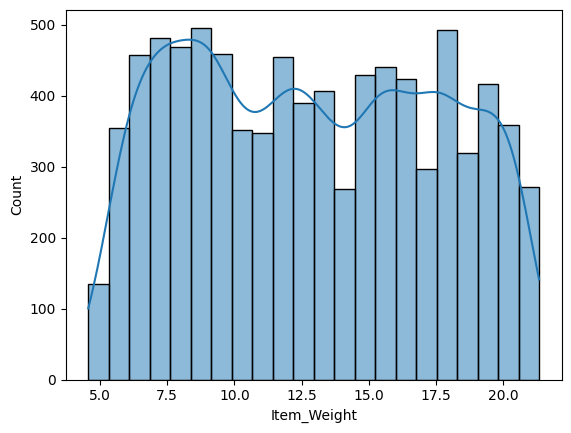

In [176]:
sns.histplot(df['Item_Weight'],kde=True)

In [177]:
bins = [0, 7, 9, 12, 15, 17, 20, df['Item_Weight'].max()]  # Define bin edges
labels = ['0-7', '7-9', '9-12', '12-15', '15-17', '17-20', '20+']  # Labels for each bin

# Apply pd.cut to bin the data
df['Item_Weight'] = pd.cut(df['Item_Weight'], bins=bins, labels=labels, include_lowest=True)

In [178]:
target_corr_check_for_categorical(df['Item_Weight'])
#keeping it for future

Item_Outlet_Sales    1.000000
Item_Weight_20+      0.017685
Item_Weight_12-15    0.013008
Item_Weight_17-20    0.001832
Item_Weight_9-12    -0.002345
Item_Weight_15-17   -0.004324
Item_Weight_7-9     -0.014503
Name: Item_Outlet_Sales, dtype: float64


In [179]:
del df['Item_Weight']

## Item_Identifier

In [180]:
col_describer(df['Item_Identifier'])

count      8519
unique     1555
top       FDW13
freq         10
Name: Item_Identifier, dtype: object
Missing: 0 (0.00%)
Distinct: 1555 (18.25%)


In [181]:
# unique variable will remove it to reduce complexity.
del df['Item_Identifier']

## Item_Visibility

In [182]:
col_describer(df['Item_Visibility'])

count    8519.000000
mean        0.066112
std         0.051586
min         0.000000
25%         0.026983
50%         0.053925
75%         0.094558
max         0.328391
Name: Item_Visibility, dtype: float64
Missing: 0 (0.00%)
Distinct: 7876 (92.45%)


In [183]:
# min contains 0. 

In [184]:
# df[df['Item_Visibility'] < 0.003]

In [185]:
target_corr_check_for_numerical(df['Item_Visibility'])

Item_Outlet_Sales    1.000000
Item_Visibility     -0.128297
Name: Item_Outlet_Sales, dtype: float64


## Item_MRP

In [186]:
col_describer(df['Item_MRP'])

count    8519.000000
mean      141.010019
std        62.283594
min        31.290000
25%        93.844900
50%       143.047000
75%       185.676600
max       266.888400
Name: Item_MRP, dtype: float64
Missing: 0 (0.00%)
Distinct: 5936 (69.68%)


<Axes: xlabel='Item_MRP', ylabel='Count'>

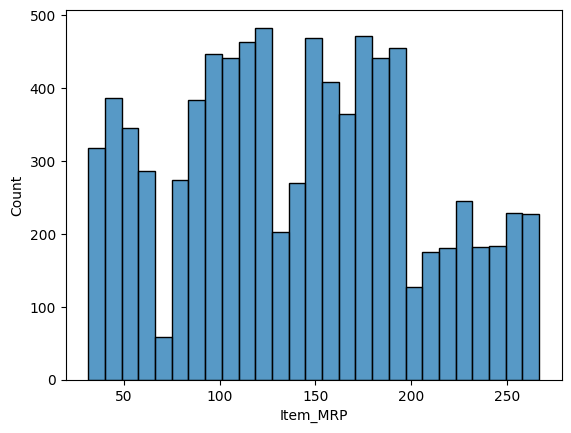

In [187]:
sns.histplot(df['Item_MRP'])

In [188]:
bins = [0, 75, 125, 175, 225, 275]
labels = ['0-75', '75-125', '125-175', '175-225', '225-275']

# Create the 'Price_Category' feature
df['Price_Category'] = pd.cut(df['Item_MRP'], bins=bins, labels=labels)

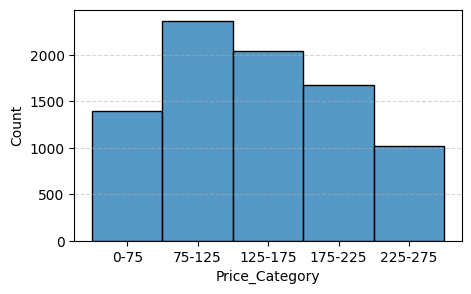

In [189]:
plt.figure(figsize=(5,3))
sns.histplot(data=df, x='Price_Category')

# Adding labels and title for clarity
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [190]:
target_corr_check_for_numerical(df['Item_MRP']) # only positive corr yet.

Item_Outlet_Sales    1.000000
Item_MRP             0.567803
Name: Item_Outlet_Sales, dtype: float64


In [191]:
target_corr_check_for_categorical(df['Price_Category'])

Item_Outlet_Sales         1.000000
Price_Category_225-275    0.347472
Price_Category_175-225    0.250519
Price_Category_125-175    0.054030
Price_Category_75-125    -0.219444
Name: Item_Outlet_Sales, dtype: float64


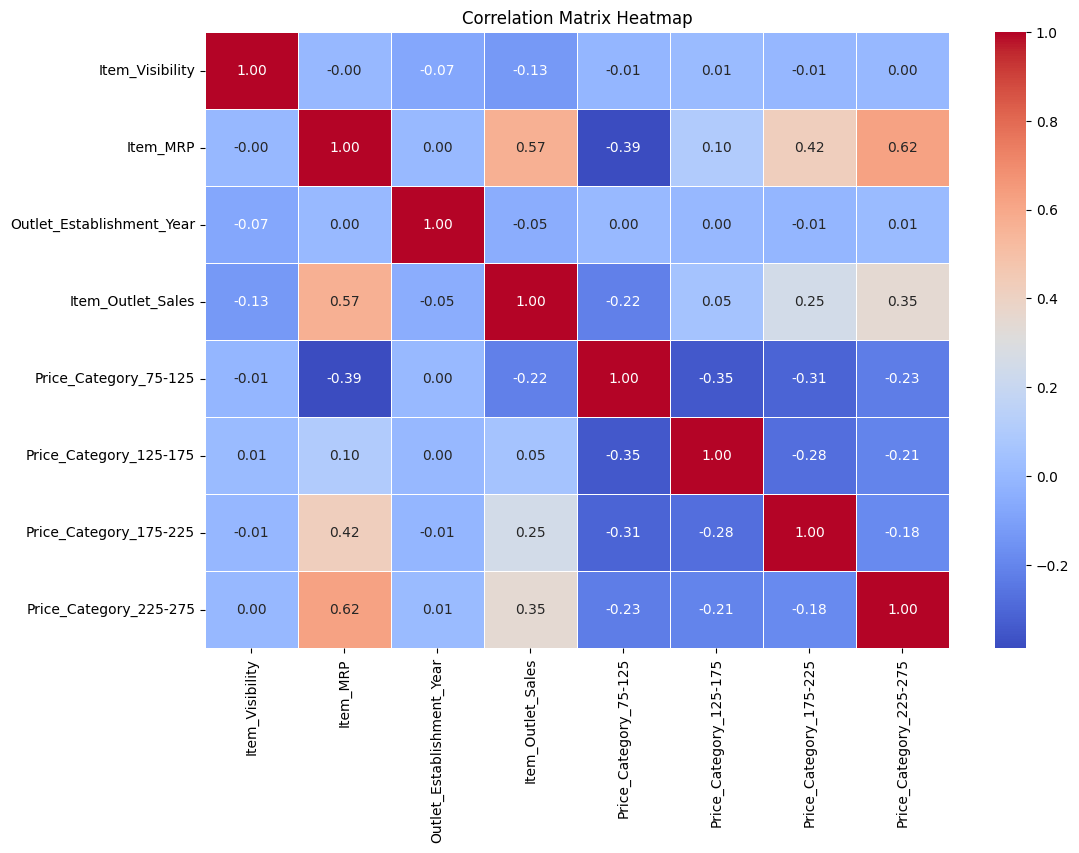

In [192]:
df_filtered = pd.get_dummies(df, columns=['Price_Category'],drop_first=True)
df_filtered = df_filtered.select_dtypes(include=['number', 'bool'])
corr_matrix = df_filtered.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [193]:
df = pd.get_dummies(df, columns=['Price_Category'],drop_first=True)

In [194]:

# will remove MRP due to multicolinearity.

del df['Item_MRP']
del df['Item_Fat_Content']
del df['Item_Type']

## Outlet_establishment_year

In [195]:
col_describer(df['Outlet_Establishment_Year'])

count    8519.000000
mean     1997.837892
std         8.369105
min      1985.000000
25%      1987.000000
50%      1999.000000
75%      2004.000000
max      2009.000000
Name: Outlet_Establishment_Year, dtype: float64
Missing: 0 (0.00%)
Distinct: 9 (0.11%)


<Axes: xlabel='Outlet_Establishment_Year', ylabel='Count'>

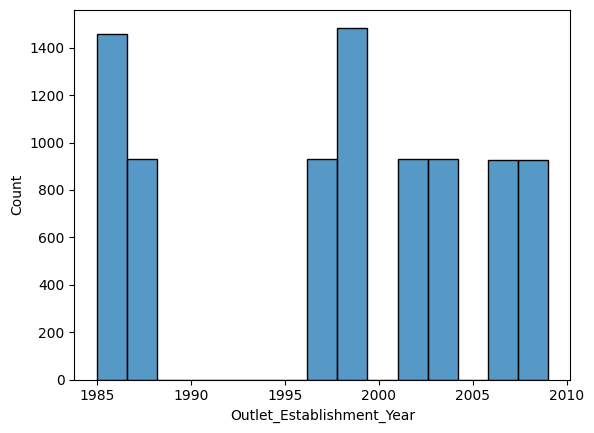

In [196]:
sns.histplot(df['Outlet_Establishment_Year'])

In [197]:
def categorize_establishment_year(year):
    if 1985 <= year <= 1990:
        return '1985-1990'
    elif 1995 <= year <= 2000:
        return '1995-2000'
    elif 2000 < year <= 2005:
        return '2000-2005'
    elif 2005 < year <= 2010:
        return '2005-2010'
    else:
        return 'Other'
df['Outlet_Establishment_Year'] = df['Outlet_Establishment_Year'].apply(categorize_establishment_year)

In [198]:
target_corr_check_for_categorical(df['Outlet_Establishment_Year'])

Item_Outlet_Sales                      1.000000
Outlet_Establishment_Year_2000-2005    0.041640
Outlet_Establishment_Year_2005-2010   -0.004107
Outlet_Establishment_Year_1995-2000   -0.118576
Name: Item_Outlet_Sales, dtype: float64


In [199]:
df = pd.get_dummies(df,columns=['Outlet_Establishment_Year'],drop_first=True)

## outlet_Size

In [200]:
col_describer(df['Outlet_Size']) #unique is only 3 so no probs.

count       6109
unique         3
top       Medium
freq        2790
Name: Outlet_Size, dtype: object
Missing: 2410 (28.29%)
Distinct: 3 (0.04%)


In [201]:
df.columns

Index(['Item_Visibility', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales',
       'Price_Category_75-125', 'Price_Category_125-175',
       'Price_Category_175-225', 'Price_Category_225-275',
       'Outlet_Establishment_Year_1995-2000',
       'Outlet_Establishment_Year_2000-2005',
       'Outlet_Establishment_Year_2005-2010'],
      dtype='object')

In [202]:
df[df['Outlet_Size'].isna()]['Outlet_Identifier'].unique()

array(['OUT010', 'OUT045', 'OUT017'], dtype=object)

In [203]:
df['Outlet_Size'].unique()

array(['Medium', nan, 'High', 'Small'], dtype=object)

In [204]:
df[df['Outlet_Identifier']=='OUT045']['Outlet_Type'].unique()

array(['Supermarket Type1'], dtype=object)

In [205]:
df.loc[(df['Outlet_Size'].isna()) & (df['Outlet_Identifier']=='OUT010'),'Outlet_Size'] = 'Small'
df.loc[(df['Outlet_Size'].isna()) & (df['Outlet_Identifier']=='OUT017'),'Outlet_Size'] = 'Medium'
df.loc[(df['Outlet_Size'].isna()) & (df['Outlet_Identifier']=='OUT045'),'Outlet_Size'] = 'High'

<Axes: xlabel='Outlet_Size', ylabel='Count'>

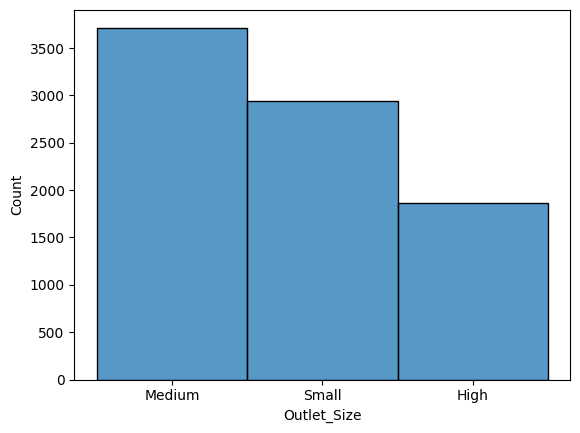

In [206]:
sns.histplot(df['Outlet_Size'])

In [207]:
target_corr_check_for_categorical(df['Outlet_Size'])

Item_Outlet_Sales     1.000000
Outlet_Size_Medium    0.213957
Outlet_Size_Small    -0.240541
Name: Item_Outlet_Sales, dtype: float64


In [208]:
df = pd.get_dummies(df,columns=['Outlet_Size'],drop_first=True)

## Outlet_identifier

In [209]:
col_describer(df['Outlet_Identifier']) # 10 outlets.

count       8519
unique        10
top       OUT027
freq         932
Name: Outlet_Identifier, dtype: object
Missing: 0 (0.00%)
Distinct: 10 (0.12%)


In [210]:
target_corr_check_for_categorical(df['Outlet_Identifier'])

Item_Outlet_Sales           1.000000
Outlet_Identifier_OUT027    0.311089
Outlet_Identifier_OUT035    0.052857
Outlet_Identifier_OUT049    0.034294
Outlet_Identifier_OUT017    0.032639
Outlet_Identifier_OUT013    0.024197
Outlet_Identifier_OUT046    0.019829
Outlet_Identifier_OUT045    0.002295
Outlet_Identifier_OUT018   -0.038048
Outlet_Identifier_OUT019   -0.276959
Name: Item_Outlet_Sales, dtype: float64


In [211]:
# we could definately see some importance.
df = pd.get_dummies(df, columns=['Outlet_Identifier'], drop_first=True)

## oulet location type

In [212]:
col_describer(df['Outlet_Location_Type'])

count       8519
unique         3
top       Tier 3
freq        3347
Name: Outlet_Location_Type, dtype: object
Missing: 0 (0.00%)
Distinct: 3 (0.04%)


In [213]:
target_corr_check_for_categorical(df['Outlet_Location_Type'])

Item_Outlet_Sales              1.000000
Outlet_Location_Type_Tier 2    0.058322
Outlet_Location_Type_Tier 3    0.046038
Name: Item_Outlet_Sales, dtype: float64


In [214]:
del df['Outlet_Location_Type']

In [215]:
#location did not have enough corelation only noise.

## Outlet Type

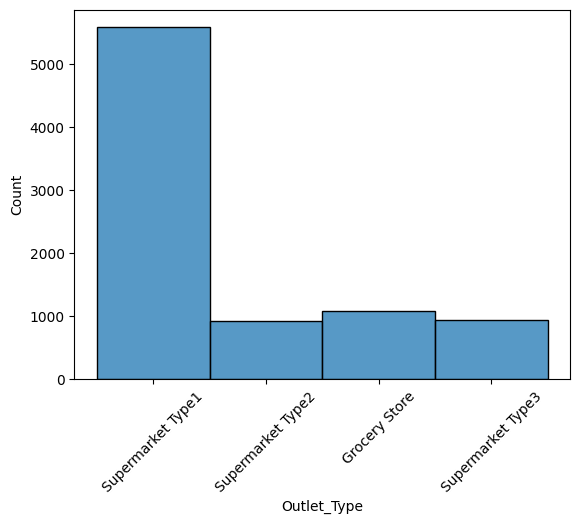

In [216]:
sns.histplot(df['Outlet_Type'])
plt.xticks(rotation=45)  # Rotates the x-axis labels by 45 degrees
plt.show()

In [217]:
target_corr_check_for_categorical(df['Outlet_Type'])

Item_Outlet_Sales                1.000000
Outlet_Type_Supermarket Type3    0.311089
Outlet_Type_Supermarket Type1    0.108919
Outlet_Type_Supermarket Type2   -0.038048
Name: Item_Outlet_Sales, dtype: float64


In [218]:
df = pd.get_dummies(df, columns=['Outlet_Type'], drop_first=True)

In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8519 entries, 0 to 8522
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Item_Visibility                      8519 non-null   float64
 1   Item_Outlet_Sales                    8519 non-null   float64
 2   Price_Category_75-125                8519 non-null   bool   
 3   Price_Category_125-175               8519 non-null   bool   
 4   Price_Category_175-225               8519 non-null   bool   
 5   Price_Category_225-275               8519 non-null   bool   
 6   Outlet_Establishment_Year_1995-2000  8519 non-null   bool   
 7   Outlet_Establishment_Year_2000-2005  8519 non-null   bool   
 8   Outlet_Establishment_Year_2005-2010  8519 non-null   bool   
 9   Outlet_Size_Medium                   8519 non-null   bool   
 10  Outlet_Size_Small                    8519 non-null   bool   
 11  Outlet_Identifier_OUT013           

In [220]:
df.drop(columns=[i for i in df.columns if re.search(r'Type|Identifier', i)],inplace=True)

# corr

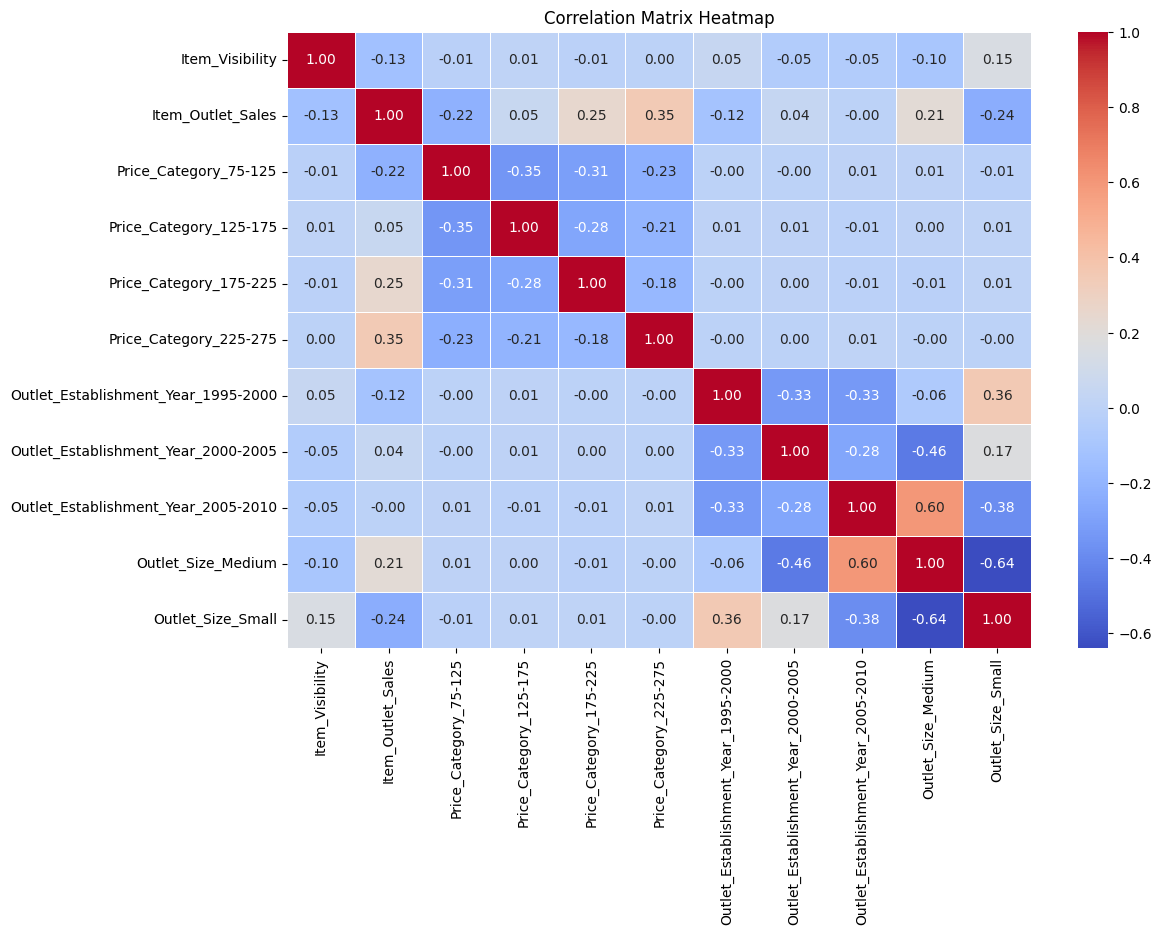

In [221]:
df_filtered = df.select_dtypes(include=['number', 'bool'])
corr_matrix = df_filtered.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [ ]:
df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})

In [223]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Assuming X is your feature DataFrame excluding the target variable
X = df.drop(columns='Item_Outlet_Sales')

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                               Feature       VIF
0                      Item_Visibility  2.367846
1                Price_Category_75-125  1.933335
2               Price_Category_125-175  1.837960
3               Price_Category_175-225  1.664646
4               Price_Category_225-275  1.406397
5  Outlet_Establishment_Year_1995-2000  2.339470
6  Outlet_Establishment_Year_2000-2005  1.651752
7  Outlet_Establishment_Year_2005-2010  2.444562
8                   Outlet_Size_Medium  3.957879
9                    Outlet_Size_Small  2.836312


# Model Dev

In [128]:
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Splitting data into features (X) and target (y)
X = df.drop('Item_Outlet_Sales', axis=1)
y = df['Item_Outlet_Sales']

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Setting up the grid search for Linear Regression
param_grid_lr = {
    'fit_intercept': [True, False],
}

lr_model = LinearRegression()
grid_search_lr = GridSearchCV(lr_model, param_grid_lr, cv=5, scoring='neg_mean_squared_error')
grid_search_lr.fit(X_train, y_train)

# Best parameters and evaluation
print("Best Parameters for Linear Regression:", grid_search_lr.best_params_)
y_pred_lr = grid_search_lr.best_estimator_.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f"Mean Squared Error for Linear Regression: {mse_lr}")


Best Parameters for Linear Regression: {'fit_intercept': True}
Mean Squared Error for Linear Regression: 1625796.6969790342


In [129]:
x = df.drop(columns=['Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3)
x_train.head()

,Item_Visibility,Price_Category_75-125,Price_Category_125-175,Price_Category_175-225,Price_Category_225-275,Outlet_Establishment_Year_1995-2000,Outlet_Establishment_Year_2000-2005,Outlet_Establishment_Year_2005-2010,Outlet_Size_Medium,Outlet_Size_Small
3524,0.105288,1,0,0,0,0,1,0,0,1
5275,0.026827,1,0,0,0,0,0,0,0,0
6919,0.044624,0,0,0,1,0,0,0,0,0
5156,0.097259,1,0,0,0,0,1,0,0,0
5803,0.072279,1,0,0,0,0,0,1,1,0


In [130]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

X = df.drop('Item_Outlet_Sales', axis=1)
y = df['Item_Outlet_Sales']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBRegressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'learning_rate': np.arange(0.01, 0.4, 0.01),
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6, 7, 8, 9]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter combinations to sample
    cv=10,  
    verbose=1,  
    n_jobs=-1,  
    random_state=42
)

# Fit RandomizedSearchCV
random_search.fit(x_train, y_train)

# Output the best parameters and cross-validation score
print("Best Parameters:", random_search.best_params_)
print("Best Cross-validation Score:", -random_search.best_score_)

# Evaluate the model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)

# Calculate the Mean Squared Error for the test set
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best Parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': np.float64(0.03)}
Best Cross-validation Score: -0.5171007308609438
Mean Squared Error on Test Set: 1402039.348366665


In [140]:
print(f'test score: {best_model.score(x_test, y_test)}')
print(f'train score: {best_model.score(x_train, y_train)}')

test score: 0.5282613661471797
train score: 0.5582924345806487


In [131]:
fimp = best_model.feature_importances_.round(3)
fimp.tolist()
Fea = x_train.columns.tolist()

val = {
    'Feature' : Fea,
    'Importances' : fimp
}

Feature = pd.DataFrame(val).sort_values(by='Importances', ascending = False)
Feature

,Feature,Importances
4,Price_Category_225-275,0.225
3,Price_Category_175-225,0.181
2,Price_Category_125-175,0.137
5,Outlet_Establishment_Year_1995-2000,0.089
6,Outlet_Establishment_Year_2000-2005,0.085
9,Outlet_Size_Small,0.078
7,Outlet_Establishment_Year_2005-2010,0.069
1,Price_Category_75-125,0.064
8,Outlet_Size_Medium,0.064
0,Item_Visibility,0.009


In [235]:
del df

In [296]:
testdf = pd.read_csv('test_AbJTz2l.csv')

In [297]:
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


In [298]:
testdf.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

In [299]:
def preprocess(df):
    bins = [0, 75, 125, 175, 225, 275]
    labels = ['0-75', '75-125', '125-175', '175-225', '225-275']

    # Create the 'Price_Category' feature
    df['Price_Category'] = pd.cut(df['Item_MRP'], bins=bins, labels=labels)
    
    df = pd.get_dummies(df, columns=['Price_Category'],drop_first=True)
    del df['Item_MRP']
    #------------------------------------------------------------------------------------------------
    def categorize_establishment_year(year):
        if 1985 <= year <= 1990:
            return '1985-1990'
        elif 1995 <= year <= 2000:
            return '1995-2000'
        elif 2000 < year <= 2005:
            return '2000-2005'
        elif 2005 < year <= 2010:
            return '2005-2010'
        else:
            return 'Other'
    df['Outlet_Establishment_Year'] = df['Outlet_Establishment_Year'].apply(categorize_establishment_year)
    
    df = pd.get_dummies(df,columns=['Outlet_Establishment_Year'],drop_first=True)
    #------------------------------------------------------------------------------------------------
    df.loc[(df['Outlet_Size'].isna()) & (df['Outlet_Identifier']=='OUT010'),'Outlet_Size'] = 'Small'
    df.loc[(df['Outlet_Size'].isna()) & (df['Outlet_Identifier']=='OUT017'),'Outlet_Size'] = 'Medium'
    df.loc[(df['Outlet_Size'].isna()) & (df['Outlet_Identifier']=='OUT045'),'Outlet_Size'] = 'High'
    df = pd.get_dummies(df,columns=['Outlet_Size'],drop_first=True)
    
    df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})

    return df
    

In [300]:
testdf = testdf[['Item_MRP','Outlet_Establishment_Year','Outlet_Size','Item_Visibility','Outlet_Identifier','Item_Identifier']]
testdf = preprocess(testdf)

In [301]:
predictions = best_model.predict(testdf[[i for i in testdf.columns if i not in ['Item_Identifier','Outlet_Identifier']]])
testdf['Item_Outlet_Sales'] = predictions.round(2)

In [302]:
testdf

,Item_Visibility,Outlet_Identifier,Item_Identifier,Price_Category_75-125,Price_Category_125-175,Price_Category_175-225,Price_Category_225-275,Outlet_Establishment_Year_1995-2000,Outlet_Establishment_Year_2000-2005,Outlet_Establishment_Year_2005-2010,Outlet_Size_Medium,Outlet_Size_Small,Item_Outlet_Sales
0,0.007565,OUT049,FDW58,1,0,0,0,1,0,0,1,0,1616.040039
1,0.038428,OUT017,FDW14,1,0,0,0,0,0,1,1,0,1627.319946
2,0.099575,OUT010,NCN55,0,0,0,1,1,0,0,0,1,2192.449951
3,0.015388,OUT017,FDQ58,0,1,0,0,0,0,1,1,0,2593.520020
4,0.118599,OUT027,FDY38,0,0,0,1,0,0,0,1,0,5944.140137
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5676,0.013496,OUT046,FDB58,0,1,0,0,1,0,0,0,1,1911.930054
5677,0.142991,OUT018,FDD47,0,1,0,0,0,0,1,1,0,2317.080078
5678,0.073529,OUT045,NCO17,1,0,0,0,0,1,0,0,0,1541.339966
5679,0.000000,OUT017,FDJ26,0,0,1,0,0,0,1,1,0,3283.330078


In [303]:
testdf[['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']].to_csv('submission.csv',index=False)